## Introduction

In this script we will be looking at implementing an LSTM using just numpy. The LSTM is used to classify reviews into either positive / negative. This is a single layered LSTM with 8 hidden units.


## Resources

The following Github Repository helped me a lot in understanding the inner workings of an LSTM -> https://github.com/CaptainE/RNN-LSTM-in-numpy/blob/master/RNN_LSTM_from_scratch.ipynb


## Import Libraries and Data

The following code snippet demonstrates an import of necessary libraries and the initial steps in processing a dataset using the pandas and numpy libraries.

First, the code imports the numpy library as `np` and the pandas library as `pd`, which are commonly used for data manipulation and analysis in Python.

The code then imports the stopwords module from the Natural Language Toolkit (NLTK) library. NLTK is a popular library for natural language processing tasks.

Next, the CSV file named 'olist_order_reviews_dataset.csv' is read using the `read_csv()` function from pandas. The dataset is stored in the variable `review_list`. 

Following that, a subset of the `review_list` dataframe is created using the double square brackets notation. This subset includes only two columns, namely 'review_score' and 'review_comment_message'. These columns are extracted and stored in the variable `review_list_subset`.

In summary, the code snippet imports necessary libraries, reads a CSV file containing order review data, and creates a subset of the dataset with only the 'review_score' and 'review_comment_message' columns.

In [1]:
import numpy as np
import pandas as pd


from nltk.corpus import stopwords
review_list = pd.read_csv('olist_order_reviews_dataset.csv')
review_list_subset = review_list[['review_score','review_comment_message']]


## Filter the data and create "sentiment" column

In the following step, we do multiple levels of data processing to clean and preprocess text data contained in the `review_list_subset` dataframe. It includes removing stopwords, converting text to lowercase, replacing punctuation and digits with whitespace, and dropping null values.

It also adds a new column called 'sentiment' to the dataframe, which is based on the `review score` column. Reviews with scores below 4 are labeled as 'NEG', and those with scores 4 and above are labeled as 'POS'.

Finally, the script filters the dataframe to keep only 10,000 positive and 10,000 negative reviews(for a balanced dataset), concatenates them, shuffles the resulting dataframe, and drops any remaining null values. 

In [2]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)



review_list_subset = review_list_subset.loc[~review_list_subset['review_comment_message'].isna()]

review_list_subset['sentiment'] = 'POS'

review_list_subset.loc[review_list_subset['review_score']<4,'sentiment']= 'NEG'



review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.lower()


review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('!',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('.',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace(',',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('-',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('_',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('0|1|2|3|4|5|6|7|8|9',' ',regex=True)


review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].apply(remove_stopwords)

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.strip()


# review_list_subset['len'] = review_list_subset['review_comment_message'].apply(lambda x: len(x.split()))




review_list_subset.reset_index(inplace = True)

review_list_subset.drop('index',inplace=True,axis=1)

review_list_pos = review_list_subset[review_list_subset['sentiment']=='POS']

review_list_pos = review_list_pos.head(10000)

review_list_neg = review_list_subset[review_list_subset['sentiment']=='NEG']

review_list_neg = review_list_neg.head(10000)



print(review_list_neg.shape)

print(review_list_pos.shape)


review_list_subset = pd.concat([review_list_neg,review_list_pos])

review_list_subset = review_list_subset.sample(frac = 1,random_state=42)

review_list_subset.dropna(inplace = True)      



/tmp/ipykernel_20/558343048.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('.',' ')


(10000, 3)
(10000, 3)


## Create a dataset

We create two lists ; `text_list` & `labels_list`. As the names suggest, the first one is for the text data and the second one for the sentiment labels.

In [3]:
np.random.seed(42)


samples = []
labels = []



text_list = review_list_subset['review_comment_message'].tolist()

sentiment_list = review_list_subset['sentiment'].tolist()

for i in range(len(text_list)):
    
    append_list = text_list[i].split(' ')
    
    if '' in append_list:
        count_ = append_list.count('')
        for j in range(count_):
            append_list.remove('')
    samples.append(append_list)
    labels.append(sentiment_list[i])

## Create a dictionary of unique words

The following step takes the list of text (generated from the previous step) and flattens it into a single list of words. We then count the frequency of each unique word in the list and sort them in descending order of frequency.

The resulting list of unique words is then used to create two dictionaries: `word_to_idx`, which maps each unique word to a corresponding index, and `idx_to_word`, which maps each index to its corresponding word.

Finally, we compute the number of sentences and vocabulary size (number of unique words) and appends a token 'UNK' to the unique_words list, which is used to represent any out-of-vocabulary (OOV) words that are not present in the dictionary.



In [4]:

sequences = samples

### A single sample in generated dataset

print(sequences[0])
print(len(sequences))

from collections import defaultdict


## Function to flatten the 3D list 
flatten = lambda l : [item for sublist in l for item in sublist]

all_words = flatten(sequences)

word_count = defaultdict(int)

for word in flatten(sequences):
    word_count[word]+=1

## Sort wound count by frequency

word_count = sorted(list(word_count.items()),key=lambda l : -l[1])

## List of all unique words

unique_words = [item[0] for item in word_count]

unique_words.append('UNK')

## Number of sentences and vocab size

number_of_sentences,vocab_size = len(sequences),len(unique_words)

## Word to index and Index to word dictionaries

word_to_idx = defaultdict(lambda:vocab_size)
idx_to_word = defaultdict(lambda : 'UNK')

for idx,word in enumerate(unique_words):
    word_to_idx[word] = idx
    idx_to_word[idx] = word

['compra', 'feita', 'entregue', 'prazo', 'recomendo', 'loja', 'site', 'lannister']
20000


## Train and Test Set

We then split our dataset into train(80%) and test sets(20%).

In [5]:
# divide the data into train test and valid
p_train = 0.8
p_val = 0.1
p_test = 0.1

num_train = int(len(sequences))*p_train
num_val = int(len(sequences))*p_val
num_test = int(len(sequences))*p_test

inputs, targets = [],[]
## Use the last "word" as a target
for i in range(len(sequences)):
    
    
    inputs.append(sequences[i])
    targets.append(labels[i])

    
X_train,y_train = inputs[:int(num_train)],targets[:int(num_train)]

X_val, y_val = inputs[int(num_train):int(num_train)+int(num_val)],targets[int(num_train):int(num_train)+int(num_val)]

X_test, y_test = inputs[int(num_train)+int(num_val):int(num_train)+int(num_val)+int(num_test)],targets[int(num_train)+int(num_val):int(num_train)+int(num_val)+int(num_test)]


## Functions for one hot encoding and activation functions

The `output_map` dictionary maps the output labels 'NEG' and 'POS' to the integer values 0 and 1, respectively. The one_hot_encode_output function takes an output label and returns a one-hot encoded numpy array of length 2, where the appropriate element is set to 1 based on the label.

The `one_hot_encode` function takes an index and the size of the vocabulary and returns a one-hot encoded numpy array of length vocab_size, where the appropriate element is set to 1 based on the index.

The `one_hot_encode_sequence` function takes a sequence of words and the size of the vocabulary and returns a 3-D numpy array of shape (num words, vocab size, 1) where each word is one-hot encoded.

The `sigmoid`, `softmax`, `tanh`, `ReLU`, and `dReLU` functions are activation functions. `dReLU` is the function for the derivative of ReLU.

The `init_orthogonal` function initializes weight parameters orthogonally using the QR factorization method as described in this paper: https://arxiv.org/abs/1312.6120. It takes a numpy array of weight parameters and returns a new array with the same shape that has been initialized orthogonally.



In [6]:
output_map = {

0 : 'NEG',
1 : 'POS'

}

def one_hot_encode_output(output_text):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    
    one_hot = np.zeros(2)
    
    # Set the appropriate element to one
    
    if output_text =='NEG':
    
        one_hot[0] = 1.0
    elif output_text == 'POS':
        one_hot[1] = 1.0
#     else:
#         one_hot[2] = 1.0

    return one_hot


def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    
    
    
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    
    for i in range(len(sequence)):
        if not sequence[i] in unique_words:
            sequence[i] = 'UNK'
        
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


# Activation functions


    
def softmax(x,derivative = False):
    x_safe = x+1e-12
    
    f = np.exp(x_safe)/np.sum(np.exp(x_safe))
    
    if derivative:
        pass
    else:
        return(f)
    


def ReLU(x):
    return (x>0)*x

def dReLU(x):
    return (x>0)*1.0



# def clip_gradient_norm(grads, max_norm=0.):
#     """
#     Clips gradients to have a maximum norm of `max_norm`.
#     This is to prevent the exploding gradients problem.
#     """ 
#     # Set the maximum of the norm to be of type float
#     max_norm = float(max_norm)
#     total_norm = 0
    
#     # Calculate the L2 norm squared for each gradient and add them to the total norm
#     for grad in grads:
#         grad_norm = np.sum(np.power(grad, 2))
#         total_norm += grad_norm
    
#     total_norm = np.sqrt(total_norm)
    
#     print(total_norm)
    
#     # Calculate clipping coeficient
#     clip_coef = max_norm / (total_norm + 1e-6)
    
#     # If the total norm is larger than the maximum allowable norm, then clip the gradient
#     if clip_coef < 1:
#         for grad in grads:
#             grad *= clip_coef
    
#     print('Sum Grad')
#     print(grads)
#     print('----')
    
#     return grads




def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param





## Forward Propagation Through a single input


The code snippet demonstrates a simple forward propagation process in Long Short-Term Memory (LSTM) for a single input. It begins by defining the input sequence 'inputs' and the corresponding target values 'targets'. The 'hidden_size'(8) variable determines the size of the hidden state in the LSTM. 

Next, the code initializes various weight matrices (Wxi, Whi, Wxf, Whf, Wxo, Who, Wxg, Whg, W_output) and bias vectors (bi, bf, bo, bg, b_output) using random values. These parameters are essential for the LSTM calculations.

The code then defines two activation functions: 'logistic_activation', which implements the logistic function, and 'tanh_activation', which implements the hyperbolic tangent function. These functions will be used to compute the activation values of the LSTM gates.

Following that, the code initializes lists to store the intermediate values at each time step. These lists include 'hidden_states' for the LSTM hidden states, 'long_term_hidden_states' for the long-term memory states, 'it_list' for the input gates, 'ft_list' for the forget gates, 'ot_list' for the output gates, and 'gt_list' for the candidate cell states.

Next, a loop is executed over the input sequence, where each time step's calculations are performed. The LSTM equations are applied to compute the various gates and update the hidden state and memory cell values. For the first time step, the initial values are calculated using the input sequence and the random weight matrices and biases. For subsequent time steps, the previous hidden state 'h_t' is also considered in the calculations.

Finally, when the loop completes, the output 'y_t' is obtained by applying the softmax function to the weighted sum of the final hidden state and a bias vector. The intermediate values are stored in their respective lists throughout the loop.

This code snippet provides a basic implementation of forward propagation in LSTM for a single input, allowing for the computation of hidden states, memory states, and outputs at each time step.


In [7]:
## Simple forward propagation in LSTM for one input

inputs = X_train[2]
targets = y_train[2]
hidden_size = 8
inputs_one_hot = one_hot_encode_sequence(inputs,vocab_size)
targets_one_hot = one_hot_encode_output(targets).reshape(2,1)

#### i_t

Wxi = np.random.rand(hidden_size,vocab_size)
Whi = np.random.rand(hidden_size,hidden_size)
bi = np.random.rand(hidden_size,1)

#### f_t



Wxf = np.random.rand(hidden_size,vocab_size)
Whf = np.random.rand(hidden_size,hidden_size)
bf = np.random.rand(hidden_size,1)

### o_t

Wxo = np.random.rand(hidden_size,vocab_size)
Who = np.random.rand(hidden_size,hidden_size)
bo = np.random.rand(hidden_size,1)

### g_t

Wxg = np.random.rand(hidden_size,vocab_size)
Whg = np.random.rand(hidden_size,hidden_size)
bg = np.random.rand(hidden_size,1)

### Output 
W_output = np.random.rand(2,hidden_size)
b_output = np.random.rand(2,1)


def logistic_activation(z):
    """
    Implements the logistic activation function: f(z) = 1 / (1 + e^(-z))
    
    Parameters:
    z (numpy.ndarray): A numpy array of shape (8,1) containing the input values
    
    Returns:
    numpy.ndarray: A numpy array of shape (8,1) containing the output of the logistic function
    """
    return 1 / (1 + np.exp(-z))


def tanh_activation(z):
    """
    Implements the tanh activation function: f(z) = (e^z - e^(-z)) / (e^z + e^(-z))
    
    Parameters:
    z (numpy.ndarray): A numpy array containing the input values
    
    Returns:
    numpy.ndarray: A numpy array containing the output of the tanh function
    """
    return np.tanh(z)


hidden_states=[]

long_term_hidden_states = []

it_list = []

ft_list = []

ot_list = []

gt_list = []

ct_list = []




for t in range(len(inputs_one_hot)):
    
    


    if t<len(inputs_one_hot)-1:
        if t == 0:
            i_t = logistic_activation(Wxi@inputs_one_hot[t]+bi)
            f_t = logistic_activation(Wxf@inputs_one_hot[t]+bf)
            o_t = logistic_activation(Wxo@inputs_one_hot[t]+bo)
            g_t = tanh_activation(Wxg@inputs_one_hot[t]+bg)
            c_t = np.multiply(i_t,g_t)
            h_t = np.multiply(o_t,tanh_activation(c_t))
            hidden_states.append(h_t)
            long_term_hidden_states.append(c_t)
            it_list.append(i_t)
            ft_list.append(f_t)
            ot_list.append(o_t)
            gt_list.append(g_t)
            ct_list.append(c_t)
            
        else:
            i_t = logistic_activation(Wxi@inputs_one_hot[t]+Whi@h_t+bi)
            f_t = logistic_activation(Wxf@inputs_one_hot[t]+Whf@h_t+bf)
            o_t = logistic_activation(Wxo@inputs_one_hot[t]+Who@h_t+bo)
            g_t = tanh_activation(Wxg@inputs_one_hot[t]+Whg@h_t+bg)
            c_t = np.multiply(i_t,g_t)
            h_t = np.multiply(o_t,tanh_activation(c_t))
            hidden_states.append(h_t)
            long_term_hidden_states.append(c_t)
            it_list.append(i_t)
            ft_list.append(f_t)
            ot_list.append(o_t)
            gt_list.append(g_t)
            ct_list.append(c_t)
            
        

        
    else:
        
        i_t = logistic_activation(Wxi@inputs_one_hot[t]+Whi@h_t+bi)
        f_t = logistic_activation(Wxf@inputs_one_hot[t]+Whf@h_t+bf)
        o_t = logistic_activation(Wxo@inputs_one_hot[t]+Who@h_t+bo)
        g_t = tanh_activation(Wxg@inputs_one_hot[t]+Whg@h_t+bg)
        c_t = np.multiply(i_t,g_t)
        h_t = np.multiply(o_t,tanh_activation(c_t))
        y_t = softmax(W_output@h_t+b_output)
        hidden_states.append(h_t)
        long_term_hidden_states.append(c_t)
        it_list.append(i_t)
        ft_list.append(f_t)
        ot_list.append(o_t)
        gt_list.append(g_t)
        ct_list.append(c_t)

        
        
        #print(y_t)
        
        



#     hidden_states.append(hidden_state)


In [8]:
print(len(hidden_states))
print(len(long_term_hidden_states))
print(len(inputs_one_hot))
print(len(it_list))

7
7
7
7


## Running Backpropagation through one input.

The code snippet demonstrates the backpropagation process for a single input in the LSTM model. It begins by initializing variables for loss and classification accuracy. The code then enters a loop that iterates in reverse order over the input sequence.

Within the loop, calculations are performed to update the gradients for each parameter in the LSTM model. At each time step, the loss is computed by comparing the predicted output 'y_t' with the target values 'targets_one_hot'. The classification accuracy is also calculated by comparing the predicted output with the target values.

For the last time step, the gradients are computed for the weight matrix 'W_output' and the hidden state 'h_t'. The gradients for the output gate 'o_t', the cell state 'c_t', the forget gate 'f_t', the input gate 'i_t', and the candidate cell state 'g_t' are also calculated. Additionally, gradients are computed for the weight matrices and bias vectors associated with each gate.

For time steps before the last one, the gradients for 'h_t' are accumulated by adding the gradient from the subsequent time step ('d_h_t_before') to the current gradient ('d_h_t'). The gradients for the other gates and weight matrices are calculated in a similar manner as in the last time step.

Overall, this code snippet provides the implementation of backpropagation in the LSTM model for a single input. It computes the gradients for each parameter in the model, which can be used to update the weights during the training process.

In [9]:
## Back prop for one input

# dh_t = W_output.T@(y_t-targets_one_hot)
# dh_t.shape

loss = 0
classification_accuracy = 0
for t in reversed(range(len(inputs_one_hot))):
    
    print(t)

               
    if t == len(inputs_one_hot)-1:

        loss += -np.mean(np.log(y_t+0.000001) * targets_one_hot)


        classification_accuracy += int(output_map[np.argmax(y_t,axis=0)[0]] == output_map[np.argmax(targets_one_hot,axis=0)[0]])
        real_value = output_map[np.argmax(targets_one_hot,axis=0)[0]]
        predicted_value = output_map[np.argmax(y_t,axis=0)[0]]
        
        d_W_output = (y_t - targets_one_hot)@hidden_states[t].T
        d_h_t = W_output.T@(y_t - targets_one_hot)
        
        d_o_t = d_h_t@(tanh_activation(long_term_hidden_states[t-1]).T)
        
        d_z = d_h_t@ot_list[t].T
        
        d_c_t = d_z@(1 - tanh_activation(long_term_hidden_states[t-1])**2)
        
        d_f_t = d_c_t@long_term_hidden_states[t-2].T
        
        d_i_t = d_c_t@gt_list[t].T
        
        d_g_t = d_c_t@it_list[t].T
        
        d_c_B = d_g_t@(1-gt_list[t]**2)
        
        d_wxg = d_c_B@inputs_one_hot[t].T
        
        d_whg = d_c_B@hidden_states[t-2].T
        
        d_bg = d_c_B
        
        d_A = d_o_t@(np.multiply(ot_list[t],1-ot_list[t]))
        
        d_wxo = d_A @ inputs_one_hot[t].T
        
        d_who = d_A @ hidden_states[t-2].T
        
        d_bo = d_A
        
        d_G = d_f_t@(np.multiply(ft_list[t],1-ft_list[t]))
        
        d_wxf = d_G@inputs_one_hot[t].T
        
        d_whf = d_G@hidden_states[t-2].T
        
        d_bf = d_G
        
        d_F = d_i_t@(np.multiply(it_list[t],1-it_list[t]))
        
        d_wxi = d_F@inputs_one_hot[t].T
        
        d_whi = d_F@hidden_states[t-2].T
        
        d_bi = d_F
        
        d_h_t_before = Whg.T@d_c_B+Who.T@d_A+Whi.T@d_F
        

        
        
        
        
        
        
        

        



        


    else:
        
#         loss += -np.mean(np.log(y_t+0.000001) * targets_one_hot)


#         classification_accuracy += int(output_map[np.argmax(y_t,axis=0)[0]] == output_map[np.argmax(targets_one_hot,axis=0)[0]])
#         real_value = output_map[np.argmax(targets_one_hot,axis=0)[0]]
#         predicted_value = output_map[np.argmax(y_t,axis=0)[0]]
        
#         d_W_output = (y_t - targets_one_hot)@hidden_states[t].T
        d_h_t += d_h_t_before
        
        d_o_t = d_h_t@(tanh_activation(long_term_hidden_states[t-1]).T)
        
        d_z = d_h_t@ot_list[t].T
        
        d_c_t = d_z@(1 - tanh_activation(long_term_hidden_states[t-1])**2)
        
        d_f_t = d_c_t@long_term_hidden_states[t-2].T
        
        d_i_t = d_c_t@gt_list[t].T
        
        d_g_t = d_c_t@it_list[t].T
        
        d_c_B = d_g_t@(1-gt_list[t]**2)
        
        d_wxg = d_c_B@inputs_one_hot[t].T
        
        d_whg = d_c_B@hidden_states[t-2].T
        
        d_bg = d_c_B
        
        d_A = d_o_t@(np.multiply(ot_list[t],1-ot_list[t]))
        
        d_wxo = d_A @ inputs_one_hot[t].T
        
        d_who = d_A @ hidden_states[t-2].T
        
        d_bo = d_A
        
        d_G = d_f_t@(np.multiply(ft_list[t],1-ft_list[t]))
        
        d_wxf = d_G@inputs_one_hot[t].T
        
        d_whf = d_G@hidden_states[t-2].T
        
        d_bf = d_G
        
        d_F = d_i_t@(np.multiply(it_list[t],1-it_list[t]))
        
        d_wxi = d_F@inputs_one_hot[t].T
        
        d_whi = d_F@hidden_states[t-2].T
        
        d_bi = d_F
        
        d_h_t_before = Whg.T@d_c_B+Who.T@d_A+Whi.T@d_F
        
    
        
        

        
            

6
5
4
3
2
1
0


In [10]:
# print((Whg.T@d_c_B).shape)
# print((Who.T@d_A).shape)
# print((Whi.T@d_F).shape)

## Training the network

The below code is an implementation of an LSTM with the aim of training it on the entire  dataset. 

Here's a breakdown of the code:

- The code initializes various parameters and hyperparameters such as `hidden_size`, `accuracy_list`, `loss_list`, and `np.random.seed`.
- The code defines activation functions `logistic_activation` (sigmoid) and `tanh_activation` (hyperbolic tangent).
- Next, the code initializes the weight matrices and bias vectors for the LSTM-like gates (input gate, forget gate, output gate, and memory gate) and the output layer.
- The code then defines a loop for training the LSTM for a certain number of epochs (`num_epochs`).
- Within the training loop, the code iterates over the training data (`X_train` and `y_train`).
- For each input sequence (`inputs`) and target sequence (`targets`), the code performs forward propagation through the RNN and calculates the loss and classification accuracy.
- After the forward pass, the code performs backpropagation through time (BPTT) to compute the gradients of the parameters.
- The code also uses momentum and Adam optimization to update the parameters (`Wxi`, `Whi`, `bi`, etc.) based on the gradients and their respective momentums and velocities.
- Finally, the code updates the parameters using the calculated gradients and performs the weight updates using the Adam optimizer.

The `one_hot_encode_sequence` and `one_hot_encode_output` functions are responsible for encoding the input and target sequences into a one-hot representation.



In [11]:
hidden_size = 8

accuracy_list= []
loss_list = []

Wxi_list = []
Whi_list = []
bi_list = []
Wxf_list = []
Whf_list = []
bf_list = []
Wxo_list = []
Who_list = []
bo_list = []
Wxg_list = []
Whg_list = []
bg_list = []
W_output_list = []
b_output_list = []

np.random.seed(42)
#### i_t

Wxi = init_orthogonal(np.random.rand(hidden_size,vocab_size))
Whi = init_orthogonal(np.random.rand(hidden_size,hidden_size))
bi = np.random.rand(hidden_size,1)

#### f_t



Wxf = init_orthogonal(np.random.rand(hidden_size,vocab_size))
Whf = init_orthogonal(np.random.rand(hidden_size,hidden_size))
bf = np.random.rand(hidden_size,1)

### o_t

Wxo = init_orthogonal(np.random.rand(hidden_size,vocab_size))
Who = init_orthogonal(np.random.rand(hidden_size,hidden_size))
bo = np.random.rand(hidden_size,1)

### g_t

Wxg = init_orthogonal(np.random.rand(hidden_size,vocab_size))
Whg = init_orthogonal(np.random.rand(hidden_size,hidden_size))
bg = np.random.rand(hidden_size,1)

### Output 
W_output = init_orthogonal(np.random.rand(2,hidden_size))
b_output = np.random.rand(2,1)


def logistic_activation(z):
    """
    Implements the logistic activation function: f(z) = 1 / (1 + e^(-z))
    
    Parameters:
    z (numpy.ndarray): A numpy array of shape (8,1) containing the input values
    
    Returns:
    numpy.ndarray: A numpy array of shape (8,1) containing the output of the logistic function
    """
    return 1 / (1 + np.exp(-z))


def tanh_activation(z):
    """
    Implements the tanh activation function: f(z) = (e^z - e^(-z)) / (e^z + e^(-z))
    
    Parameters:
    z (numpy.ndarray): A numpy array containing the input values
    
    Returns:
    numpy.ndarray: A numpy array containing the output of the tanh function
    """
    return np.tanh(z)


hidden_states=[]

long_term_hidden_states = []

it_list = []

ft_list = []

ot_list = []

gt_list = []

ct_list = []

beta1 = 0.9
beta2 = 0.995

momentum_wxi = 0
momentum_whi = 0
momentum_bi = 0

momentum_wxf = 0
momentum_whf = 0
momentum_bf = 0

momentum_wxo = 0
momentum_who = 0
momentum_bo = 0

momentum_wxg = 0
momentum_whg = 0
momentum_bg = 0

momentum_w_output = 0
momentum_b_output = 0

velocity_wxi = 0
velocity_whi = 0
velocity_bi = 0

velocity_wxf = 0
velocity_whf = 0
velocity_bf = 0

velocity_wxo = 0
velocity_who = 0
velocity_bo = 0

velocity_wxg = 0
velocity_whg = 0
velocity_bg = 0



velocity_w_output = 0
velocity_b_output = 0





num_epochs = 110
for epoch in range(num_epochs):
    
    loss = 0
    classification_accuracy = 0
    
    d_bf = np.zeros(bf.shape)
    d_bg = np.zeros(bg.shape)
    d_bi = np.zeros(bi.shape)
    d_bo = np.zeros(bo.shape)
    d_W_output = np.zeros(W_output.shape)
    d_b_output = np.zeros(b_output.shape)
    d_whf = np.zeros(Whf.shape)
    d_whg = np.zeros(Whg.shape)
    d_whi = np.zeros(Whi.shape)
    d_who = np.zeros(Who.shape)
    
    c = 0
    for inputs,targets in zip(X_train,y_train):
        
        
        
#         c = c +1
#         print(c)
        
        if len(inputs) > 0 :
            
        

            inputs_one_hot = one_hot_encode_sequence(inputs,vocab_size)
            

            targets_one_hot = one_hot_encode_output(targets).reshape(2,1)



            hidden_states=[]

            long_term_hidden_states = []

            it_list = []

            ft_list = []

            ot_list = []

            gt_list = []

            ct_list = []



            ### For a single output

            for t in range(len(inputs_one_hot)):


                if t<len(inputs_one_hot)-1:
                    if t == 0:
                        
                        i_t = logistic_activation(Wxi@inputs_one_hot[t]+bi)
                        f_t = logistic_activation(Wxf@inputs_one_hot[t]+bf)
                        o_t = logistic_activation(Wxo@inputs_one_hot[t]+bo)
                        g_t = tanh_activation(Wxg@inputs_one_hot[t]+bg)
                        c_t = np.multiply(i_t,g_t)
                        h_t = np.multiply(o_t,tanh_activation(c_t))
                        hidden_states.append(h_t)
                        long_term_hidden_states.append(c_t)
                        it_list.append(i_t)
                        ft_list.append(f_t)
                        ot_list.append(o_t)
                        gt_list.append(g_t)
                        ct_list.append(c_t)

                    else:
                        i_t = logistic_activation(Wxi@inputs_one_hot[t]+Whi@h_t+bi)
                        f_t = logistic_activation(Wxf@inputs_one_hot[t]+Whf@h_t+bf)
                        o_t = logistic_activation(Wxo@inputs_one_hot[t]+Who@h_t+bo)
                        g_t = tanh_activation(Wxg@inputs_one_hot[t]+Whg@h_t+bg)
                        c_t = np.multiply(i_t,g_t)
                        h_t = np.multiply(o_t,tanh_activation(c_t))
                        hidden_states.append(h_t)
                        long_term_hidden_states.append(c_t)
                        it_list.append(i_t)
                        ft_list.append(f_t)
                        ot_list.append(o_t)
                        gt_list.append(g_t)
                        ct_list.append(c_t)



        
                else:

                    i_t = logistic_activation(Wxi@inputs_one_hot[t]+Whi@h_t+bi)
                    f_t = logistic_activation(Wxf@inputs_one_hot[t]+Whf@h_t+bf)
                    o_t = logistic_activation(Wxo@inputs_one_hot[t]+Who@h_t+bo)
                    g_t = tanh_activation(Wxg@inputs_one_hot[t]+Whg@h_t+bg)
                    c_t = np.multiply(i_t,g_t)
                    h_t = np.multiply(o_t,tanh_activation(c_t))
                    y_t = softmax(W_output@h_t+b_output)
                    hidden_states.append(h_t)
                    long_term_hidden_states.append(c_t)
                    it_list.append(i_t)
                    ft_list.append(f_t)
                    ot_list.append(o_t)
                    gt_list.append(g_t)
                    ct_list.append(c_t)
            


    

   
            for t in reversed(range(len(inputs_one_hot))):
                if t == len(inputs_one_hot)-1:

                    loss += -np.mean(np.log(y_t+0.000001) * targets_one_hot)


                    classification_accuracy += int(output_map[np.argmax(y_t,axis=0)[0]] == output_map[np.argmax(targets_one_hot,axis=0)[0]])
                    real_value = output_map[np.argmax(targets_one_hot,axis=0)[0]]
                    predicted_value = output_map[np.argmax(y_t,axis=0)[0]]

                    d_W_output = (y_t - targets_one_hot)@hidden_states[t].T
                    d_h_t = W_output.T@(y_t - targets_one_hot)
                    
                    d_b_output = np.sum(d_W_output,axis=1)

                    d_o_t = d_h_t@(tanh_activation(long_term_hidden_states[t]).T)

                    d_z = d_h_t@ot_list[t].T
                    

                    d_c_t = d_z@(1 - tanh_activation(long_term_hidden_states[t])**2)

                    d_f_t = d_c_t@long_term_hidden_states[t-1].T

                    d_i_t = d_c_t@gt_list[t].T

                    d_g_t = d_c_t@it_list[t].T

                    d_c_B = d_g_t@(1-gt_list[t]**2)

                    d_wxg = d_c_B@inputs_one_hot[t].T

                    d_whg = d_c_B@hidden_states[t-1].T

                    d_bg = np.sum(d_c_B,axis = 1)

                    d_A = d_o_t@(np.multiply(ot_list[t],1-ot_list[t]))

                    d_wxo = d_A @ inputs_one_hot[t].T

                    d_who = d_A @ hidden_states[t-1].T

                    d_bo = np.sum(d_A,axis=1)

                    d_G = d_f_t@(np.multiply(ft_list[t],1-ft_list[t]))

                    d_wxf = d_G@inputs_one_hot[t].T

                    d_whf = d_G@hidden_states[t-1].T

                    d_bf = np.sum(d_G,axis = 1)

                    d_F = d_i_t@(np.multiply(it_list[t],1-it_list[t]))

                    d_wxi = d_F@inputs_one_hot[t].T

                    d_whi = d_F@hidden_states[t-1].T

                    d_bi = np.sum(d_F,axis = 1)

                    d_h_t_before = Whg.T@d_c_B+Who.T@d_A+Whi.T@d_F

















                else:
                    



                    d_h_t += d_h_t_before

                    d_o_t = d_h_t@(tanh_activation(long_term_hidden_states[t]).T)

                    d_z = d_h_t@ot_list[t].T

                    d_c_t = d_z@(1 - tanh_activation(long_term_hidden_states[t])**2)

                    d_f_t = d_c_t@long_term_hidden_states[t-1].T

                    d_i_t = d_c_t@gt_list[t].T

                    d_g_t = d_c_t@it_list[t].T

                    d_c_B = d_g_t@(1-gt_list[t]**2)

                    d_wxg += d_c_B@inputs_one_hot[t].T

                    d_whg += d_c_B@hidden_states[t-1].T

                    d_bg += np.sum(d_c_B,axis = 1)

                    d_A = d_o_t@(np.multiply(ot_list[t],1-ot_list[t]))

                    d_wxo += d_A @ inputs_one_hot[t].T

                    d_who += d_A @ hidden_states[t-2].T

                    d_bo += np.sum(d_A,axis = 1)

                    d_G = d_f_t@(np.multiply(ft_list[t],1-ft_list[t]))

                    d_wxf += d_G@inputs_one_hot[t].T

                    d_whf += d_G@hidden_states[t-1].T

                    d_bf += np.sum(d_G,axis = 1)

                    d_F = d_i_t@(np.multiply(it_list[t],1-it_list[t]))

                    d_wxi += d_F@inputs_one_hot[t].T

                    d_whi += d_F@hidden_states[t-1].T

                    d_bi += np.sum(d_F,axis = 1)

                    d_h_t_before = Whg.T@d_c_B+Who.T@d_A+Whi.T@d_F
                    
            
            
            momentum_wxi = beta1*momentum_wxi + ((1-beta1)*d_wxi)
            momentum_whi = beta1*momentum_whi + ((1-beta1)*d_whi)
            momentum_bi = beta1*momentum_bi + ((1-beta1)*d_bi.reshape(d_bi.shape[0],1))
            
            momentum_wxf = beta1*momentum_wxf + ((1-beta1)*d_wxf)
            momentum_whf = beta1*momentum_whf + ((1-beta1)*d_whf)
            momentum_bf = beta1*momentum_bf + ((1-beta1)*d_bf.reshape(d_bf.shape[0],1))
            
            
            momentum_wxo = beta1*momentum_wxo + ((1-beta1)*d_wxo)
            momentum_who = beta1*momentum_who + ((1-beta1)*d_who)
            momentum_bo = beta1*momentum_bo + ((1-beta1)*d_bo.reshape(d_bo.shape[0],1))
            
            momentum_wxg = beta1*momentum_wxg + ((1-beta1)*d_wxg)
            momentum_whg = beta1*momentum_whg + ((1-beta1)*d_whg)
            momentum_bg = beta1*momentum_bg + ((1-beta1)*d_bg.reshape(d_bg.shape[0],1))
            
            momentum_w_output = beta1*momentum_w_output + ((1-beta1)*d_W_output)
            momentum_b_output = beta1*momentum_b_output + ((1-beta1)*d_b_output.reshape(d_b_output.shape[0],1))
            
            
            
            velocity_wxi = beta2*velocity_wxi + ((1-beta2)*d_wxi**2)
            velocity_whi = beta2*velocity_whi + ((1-beta2)*d_whi**2)
            velocity_bi = beta2*velocity_bi + ((1-beta2)*d_bi.reshape(d_bi.shape[0],1)**2)
            
            velocity_wxf = beta2*velocity_wxf + ((1-beta2)*d_wxf**2)
            velocity_whf = beta2*velocity_whf + ((1-beta2)*d_whf**2)
            velocity_bf = beta2*velocity_bf + ((1-beta2)*d_bf.reshape(d_bf.shape[0],1)**2)
            
            velocity_wxo = beta2*velocity_wxo + ((1-beta2)*d_wxo**2)
            velocity_who = beta2*velocity_who + ((1-beta2)*d_who**2)
            velocity_bo = beta2*velocity_bo + ((1-beta2)*d_bo.reshape(d_bo.shape[0],1)**2)
            
            velocity_wxg = beta2*velocity_wxg + ((1-beta2)*d_wxg**2)
            velocity_whg = beta2*velocity_whg + ((1-beta2)*d_whg**2)
            velocity_bg = beta2*velocity_bg + ((1-beta2)*d_bg.reshape(d_bg.shape[0],1)**2)


            
            velocity_w_output = beta2*velocity_w_output + ((1-beta2)*d_W_output**2)
            velocity_b_output = beta2*velocity_b_output + ((1-beta2)*d_b_output.reshape(d_b_output.shape[0],1)**2)
            
           
            
            
                    
#             #### i_t
            Wxi = Wxi - 0.0003 * momentum_wxi/np.sqrt(velocity_wxi+0.0000001)
            Whi = Whi - 0.0003 * momentum_whi/np.sqrt(velocity_whi+0.0000001)
            bi = bi - 0.0003 * momentum_bi/np.sqrt(velocity_bi+0.0000001)
            
            Wxf = Wxf - 0.0003 * momentum_wxf/np.sqrt(velocity_wxf+0.0000001)
            Whf = Whf - 0.0003 * momentum_whf/np.sqrt(velocity_whf+0.0000001)
            bf = bf - 0.0003 * momentum_bf/np.sqrt(velocity_bf+0.0000001)
            
            Wxo = Wxo - 0.0003 * momentum_wxo/np.sqrt(velocity_wxo+0.0000001)
            Who = Who - 0.0003 * momentum_who/np.sqrt(velocity_who+0.0000001)
            bo = bo - 0.0003 * momentum_bo/np.sqrt(velocity_bo+0.0000001)
            
            Wxg = Wxg - 0.0003 * momentum_wxg/np.sqrt(velocity_wxg+0.0000001)
            Whg = Whg - 0.0003 * momentum_whg/np.sqrt(velocity_whg+0.0000001)
            bg = bg - 0.0003 * momentum_bg/np.sqrt(velocity_bg+0.0000001)
            
            
            W_output = W_output - 0.0003*momentum_w_output/np.sqrt(velocity_w_output+0.0000001)
            b_output = b_output - 0.0003*momentum_b_output/np.sqrt(velocity_b_output+0.0000001)

#             Wxi = Wxi - 0.00003*d_wxi
#             Whi = Whi - 0.0003*d_whi
#             bi = bi - 0.0003*d_bi.reshape(d_bi.shape[0],1)

# #             #### f_t
#             Wxi = Wxi - 0.00003*d_wxi
#             Whi = Whi - 0.0003*d_whi
#             bi = bi - 0.0003*d_bi.reshape(d_bi.shape[0],1)



#             Wxf = Wxf - 0.0003*d_wxf
#             Whf = Whf - 0.0003*d_whf
#             bf = bf - 0.0003*d_bf.reshape(d_bf.shape[0],1)

# #             ### o_t

#             Wxo = Wxo - 0.0003*d_wxo
#             Who = Who - 0.0003*d_who
#             bo = bo - 0.0003*d_bo.reshape(d_bo.shape[0],1)

# #             ### g_t

#             Wxg = Wxg - 0.0003*d_wxg
#             Whg = Whg - 0.0003*d_whg
#             bg = bg - 0.0003*d_bg.reshape(d_bg.shape[0],1)

# #             ### Output 
#             W_output = W_output - 0.0003*d_W_output
#             b_output = b_output- 0.0003*d_b_output.reshape(d_b_output.shape[0],1)
                    
                
                    
    if epoch % 1 == 0:
        
        

        # Append each parameter to the respective list
        Wxi_list.append(Wxi)
        Whi_list.append(Whi)
        bi_list.append(bi)
        Wxf_list.append(Wxf)
        Whf_list.append(Whf)
        bf_list.append(bf)
        Wxo_list.append(Wxo)
        Who_list.append(Who)
        bo_list.append(bo)
        Wxg_list.append(Wxg)
        Whg_list.append(Whg)
        bg_list.append(bg)
        W_output_list.append(W_output)
        b_output_list.append(b_output)
        
#         w_list.append(W)
#         u_list.append(U)
#         v_list.append(V)
#         b_hidden_list.append(b_hidden)
#         b_out_list.append(b_out)
#         loss_list.append(loss)
        accuracy_list.append(classification_accuracy/len(X_train))
        
        print('Epoch Number : ',epoch)
        print("Classification Accuracy" ,accuracy_list[len(accuracy_list)-1])
        loss_list.append(loss)
        print("Loss :" , loss_list[len(loss_list)-1])
        if len(loss_list)>2:
            if loss_list[len(loss_list)-1] > loss_list[len(loss_list)-2]:
                print("DANGER ZONE")             
                    
                
                    
                    
                    
                    






Epoch Number :  0
Classification Accuracy 0.547
Loss : 5546.567587253155
Epoch Number :  1
Classification Accuracy 0.6698125
Loss : 5405.516163138763
Epoch Number :  2
Classification Accuracy 0.704125
Loss : 5286.779703134028
Epoch Number :  3
Classification Accuracy 0.71625
Loss : 5177.316678403021
Epoch Number :  4
Classification Accuracy 0.722375
Loss : 5082.00657653195
Epoch Number :  5
Classification Accuracy 0.725625
Loss : 4999.548749651793
Epoch Number :  6
Classification Accuracy 0.7268125
Loss : 4935.901606861843
Epoch Number :  7
Classification Accuracy 0.728125
Loss : 4893.2436520246565
Epoch Number :  8
Classification Accuracy 0.7161875
Loss : 4865.511183428564
Epoch Number :  9
Classification Accuracy 0.7043125
Loss : 4845.505021693078
Epoch Number :  10
Classification Accuracy 0.7004375
Loss : 4828.004500009988
Epoch Number :  11
Classification Accuracy 0.6965625
Loss : 4808.427890995666
Epoch Number :  12
Classification Accuracy 0.6960625
Loss : 4783.5109996623305
Epoch

In [12]:
d_W_output.shape

(2, 8)

In [13]:
inputs_one_hot[t].shape

(12042, 1)

## Training Loss across epochs

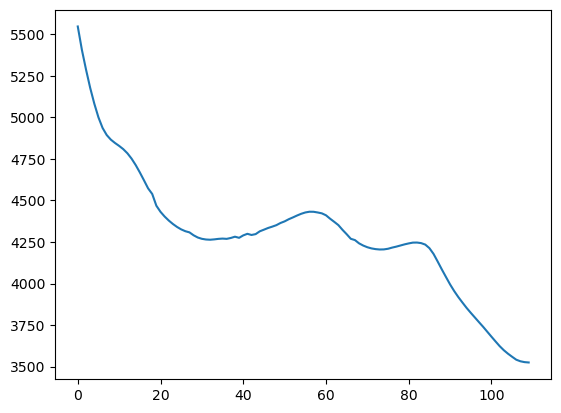

In [14]:
x = [i for i in range(len(accuracy_list))]
y = loss_list


import matplotlib.pyplot as plt
plt.plot(x,y)

## Training Accuracy across epochs

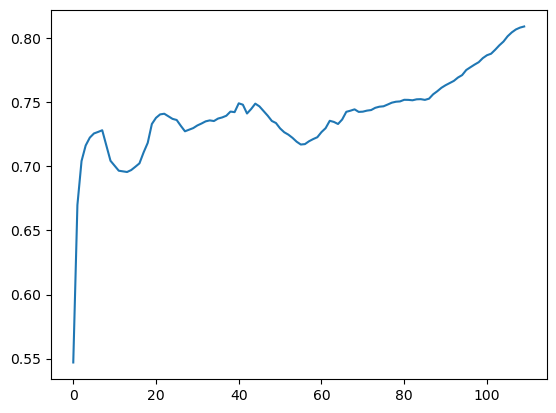

In [15]:
x = [i for i in range(len(accuracy_list))]
y = accuracy_list


import matplotlib.pyplot as plt
plt.plot(x,y)

## Save the list of weights , losses and accuracy metrics

In [16]:
# w_list.append(W)
# u_list.append(U)
# v_list.append(V)
# b_hidden_list.append(b_hidden)
# b_out_list.append(b_out)

In [17]:
# Define the filenames for saving each parameter
filename_Wxi = 'Wxi.npy'
filename_Whi = 'Whi.npy'
filename_bi = 'bi.npy'
filename_Wxf = 'Wxf.npy'
filename_Whf = 'Whf.npy'
filename_bf = 'bf.npy'
filename_Wxo = 'Wxo.npy'
filename_Who = 'Who.npy'
filename_bo = 'bo.npy'
filename_Wxg = 'Wxg.npy'
filename_Whg = 'Whg.npy'
filename_bg = 'bg.npy'
filename_W_output = 'W_output.npy'
filename_b_output = 'b_output.npy'

# Save the parameters using np.save
np.save(filename_Wxi, Wxi_list)
np.save(filename_Whi, Whi_list)
np.save(filename_bi, bi_list)
np.save(filename_Wxf, Wxf_list)
np.save(filename_Whf, Whf_list)
np.save(filename_bf, bf_list)
np.save(filename_Wxo, Wxo_list)
np.save(filename_Who, Who_list)
np.save(filename_bo, bo_list)
np.save(filename_Wxg, Wxg_list)
np.save(filename_Whg, Whg_list)
np.save(filename_bg, bg_list)
np.save(filename_W_output, W_output_list)
np.save(filename_b_output, b_output_list)



In [18]:
# import pickle
# with open('accuracy_list.pickle', 'wb') as f:
#     pickle.dump(accuracy_list, f)
    
# with open('loss_list.pickle', 'wb') as f:
#     pickle.dump(loss_list, f)